# Running scenarios

Here we show how multiple scenarios can be run using the OpenSCM Two Layer Model package.

In [1]:
# NBVAL_IGNORE_OUTPUT
import os.path

import numpy as np
import pandas as pd
import openscm_units.unit_registry as ur
import tqdm.autonotebook as tqdman
from scmdata import ScmRun

from openscm_twolayermodel import TwoLayerModel

import matplotlib.pyplot as plt

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


For this we use RCMIP effective radiative forcing data.

In [2]:
DATA_PATH = os.path.join(
    "..",
    "tests",
    "test-data",
    "rcmip-radiative-forcing-annual-means-v4-0-0.csv",
)
DATA_PATH

'../tests/test-data/rcmip-radiative-forcing-annual-means-v4-0-0.csv'

In [3]:
# NBVAL_IGNORE_OUTPUT
scenarios = ScmRun(DATA_PATH, lowercase_cols=True).filter(scenario="historical", keep=False)
scenarios

<scmdata.ScmRun (timeseries: 480, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	           model          scenario region  \
	0            AIM             rcp60  World   
	1            AIM             rcp60  World   
	2            AIM             rcp60  World   
	3            AIM             rcp60  World   
	4            AIM             rcp60  World   
	..           ...               ...    ...   
	494  unspecified  historical-cmip5  World   
	495  unspecified  historical-cmip5  World   
	496  unspecified  historical-cmip5  World   
	497  unspecified  historical-cmip5  World   
	498  unspecified  historical-cmip5  World   
	
	                                              variable   unit mip_era  \
	0                                    Radiative Forcing  W/m^2   CMIP5   
	1                      Radiative Forcing|Anthropogenic  W/m^2   CMIP5   
	2             Radiative Forcing|Anthropogenic|Aerosols  W/m^2   CMIP5   
	3    Radiative Forcing|Anthropo

We can then run them, for a number of parameter settings, as shown.

In [4]:
a_values = np.array([0, 0.01]) * ur("W/m^2/delta_degC^2")
a_values

array([0.  , 0.01]) <Unit('watt / delta_degree_Celsius ** 2 / meter ** 2')>

In [5]:
def df_append(inp):
    # TODO: ask Jared why this hack is needed
    tmp = pd.concat([i.timeseries().reset_index() for i in inp], axis=0,)

    def is_time(x):
        try:
            x.year
            return True
        except AttributeError:
            return False

    time_cols = tmp.columns.map(lambda x: hasattr(x, "year"))
    meta_cols = tmp.columns[~(time_cols.values.astype(bool))].tolist()
    tmp = tmp.set_index(meta_cols)

    return ScmRun(tmp)

In [6]:
# NBVAL_IGNORE_OUTPUT
runner = TwoLayerModel()
output = []
for a in tqdman.tqdm(a_values, desc="Parameter settings"):
    runner.a = a
    output.append(runner.run_scenarios(scenarios))

output = df_append(output)
output

<scmdata.ScmRun (timeseries: 80, timepoints: 751)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2500-01-01T00:00:00
Meta:
	             model                   scenario region  \
	699        AIM/CGE                     ssp370  World   
	700        AIM/CGE                     ssp370  World   
	701        AIM/CGE                     ssp370  World   
	702        AIM/CGE                     ssp370  World   
	703        AIM/CGE  ssp370-lowNTCF-aerchemmip  World   
	..             ...                        ...    ...   
	774  REMIND-MAGPIE                ssp534-over  World   
	775  REMIND-MAGPIE                     ssp585  World   
	776  REMIND-MAGPIE                     ssp585  World   
	777  REMIND-MAGPIE                     ssp585  World   
	778  REMIND-MAGPIE                     ssp585  World   
	
	                        variable        unit mip_era  \
	699  Effective Radiative Forcing       W/m^2   CMIP6   
	700    Surface Temperature|Upper  delta_degC   CMIP6   
	701    Surface Temperatur

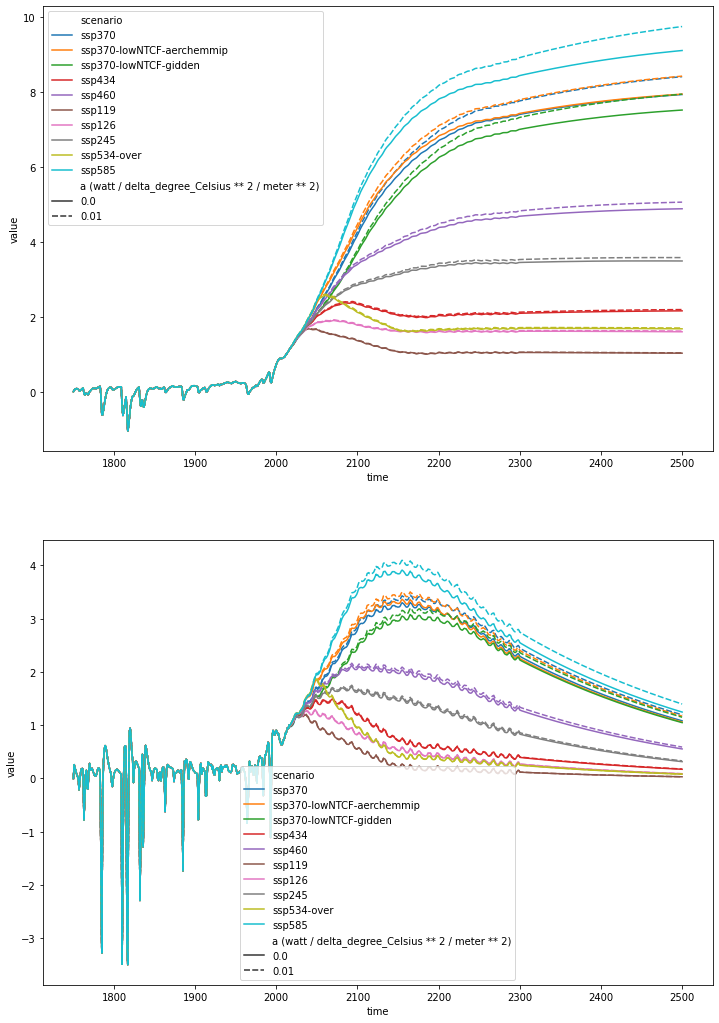

In [7]:
# NBVAL_IGNORE_OUTPUT
pkwargs = dict(
    hue="scenario", style="a (watt / delta_degree_Celsius ** 2 / meter ** 2)",
)
fig = plt.figure(figsize=(12, 18))

ax = fig.add_subplot(211)
output.filter(variable="Surface Temperature|Upper").lineplot(**pkwargs, ax=ax)

ax = fig.add_subplot(212)
output.filter(variable="Heat Uptake").lineplot(**pkwargs, ax=ax)